# エンゼルの出現確率を予測する
- pymc3対応版

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import ChocoUtils as util

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import pymc3 as pm
import scipy.stats as stats

# データの取得
- データはDB（sqlite）に保存されている
    - テーブル定義は、ブログに載っている通り

In [2]:
data = util.get_data(
    db_file='../../data/choco-ball.db', 
    filter_str='campaign is not 1 and taste is not 10')

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1 and taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (290, 14)


# エンゼル出現確率予測
## 最尤推定

In [3]:
# 最尤推定量
## 金のエンゼル
data_angel_g = np.array([1 if a==2 else 0 for a in data['angel'].values])
p_MLE_g = np.mean(data_angel_g)
## 銀のエンゼル
data_angel_s = np.array([1 if a==1 else 0 for a in data['angel'].values])
p_MLE_s = np.mean(data_angel_s)

print('gold angel rate(freq):%.3f'%(p_MLE_g))
print('silver angel rate(freq):%.3f'%(p_MLE_s))

gold angel rate(freq):0.000
silver angel rate(freq):0.048


## ベイズ推定

### モデル
- データ過程：ベルヌーイ分布（確率pで事象が発生し、(1-p)で発生しない） ←pymc3でパラメータが収束しないので、二項分布に変更
- 事前分布：一様分布（0~1の実数を取る分布）

#### pymc3の挙動がおかしい？
- 観測値が全て0の場合のBernoulli分布
- パラメータの更新がされていないっぽい?
- ポアソン分布を仮定すると収束 → 今回のモデルには当てはまらないんじゃない？
- ベータ分布を事前分布にして、事前分布に強い仮定を置く(特定の値に山をつける)と、収束するが、事前分布と変わらない → パラメータ更新されてない？
- 全ての試行に対して, 和をとって、二項分布をモデルに使うと、想定した値に収束する
- やはりベルヌーイ分布の挙動が不思議だ
    - 入力する値の型の問題だったりする？

In [4]:
def getMCMCResult(data, n_sample=2000):
    """
    MCMCでエンゼルの出現確率を予測する
    Args:
        data:エンゼルの観測結果(array)
        n_sample:MCMCシミュレーションの回数(integer)
        n_burn:捨てる数(integer)
    """
    with pm.Model() as model_g:
        #theta = pm.Uniform('theta', lower=0, upper=1) # 一様分布
        theta = pm.Beta('theta', alpha=1.0, beta=1.0)
        #theta = pm.Beta('theta', alpha=1, beta=100)
        obs = pm.Binomial('obs', n=len(data), p=theta, observed=sum(data))
        #obs = pm.Bernoulli('obs', p=theta, observed=data)
        start = pm.find_MAP() 
        #step = pm.Metropolis()
        trace = pm.sample(n_sample, start=start, chains=4)
        #trace = pm.sample(n_sample, step=step, start=start, chains=4)
    return trace

trace_g = getMCMCResult(data_angel_g)
trace_s = getMCMCResult(data_angel_s)


/Users/tok41/workspace/choco-ball-statistics/env_choco/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9.2194e-05, ||grad|| = 0.0001115: 100%|██████████| 26/26 [00:00<00:00, 2753.35it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4764.57draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/tok41/workspace/choco-ball-statistics/env_choco/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS 

In [5]:
def plot_estimate_result(trace, p_range=(0, 0.5)):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    
    ret = ax.hist(trace, bins=np.linspace(p_range[0], p_range[1], 50), density=True,
                  color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
    N = len(trace)
    bci_g = np.sort(trace)[int(N * 0.95)]
    bci_l = np.sort(trace)[int(N * 0.05)]
    ax.vlines(x=bci_g, ymin=0, ymax=ret[0].max(),
              label='90% BayesCredibleInterval',
              color='red', linestyles='--', linewidths=2)
    ax.vlines(x=bci_l, ymin=0, ymax=ret[0].max(),
              color='red', linestyles='--', linewidths=2)
    ax.legend(loc="upper right")
    ax.set_title('observation number = %d' % (len(data_angel_s)))

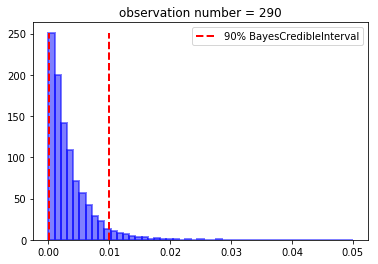

In [6]:
plot_estimate_result(trace=trace_g['theta'], p_range=(0, 0.05))

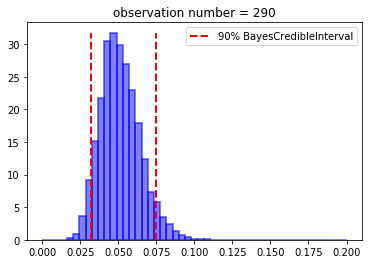

In [7]:
plot_estimate_result(trace=trace_s['theta'], p_range=(0, 0.2))

### 観測データ数毎の事後分布の推移

#### 静止画

/Users/tok41/workspace/choco-ball-statistics/env_choco/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -0.0019693, ||grad|| = 0.0019689: 100%|██████████| 20/20 [00:00<00:00, 2755.60it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4789.47draws/s]
The acceptance probability does not match the target. It is 0.7096299669880656, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/tok41/workspace/choco-ball-statistics/env_choco/lib/python3.7/site-packages/matplotlib/axes/_axes.py:

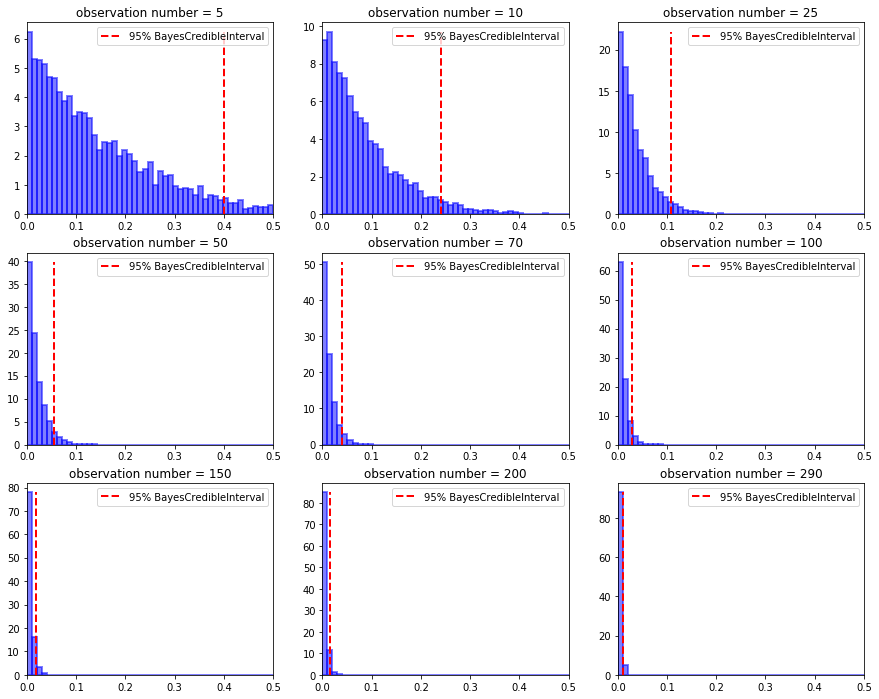

In [8]:
plt.figure(figsize=(15, 12))

#n_list = [2, 5, 10, 20, 30, 43]
n_list = [5, 10, 25, 50, 70, 100, 150, 200, 290]
cnt=0

for n in n_list:
    cnt+=1
    plt.subplot(3,3,cnt)
    p_trace = getMCMCResult(data_angel_g[:n])
    ret = plt.hist(p_trace['theta'], bins=np.linspace(0, 0.5, 50), normed=True, 
                   color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
    plt.xlim([0, 0.5])
    N = len(p_trace['theta'])
    bci = np.sort(p_trace['theta'])[int(N*0.95)]
    plt.vlines(x=bci, ymin=0, ymax=ret[0].max(), label='95% BayesCredibleInterval', 
               color='red', linestyles='--', linewidths=2)
    plt.legend()
    plt.title('observation number = %d'%n)
#plt.savefig('fig/estimate_angel_rate_silver_20171224.png')

logp = -0.0019693, ||grad|| = 0.0019689: 100%|██████████| 20/20 [00:00<00:00, 2529.05it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3962.59draws/s]
logp = -3.1248, ||grad|| = 3: 100%|██████████| 7/7 [00:00<00:00, 1885.32it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4406.10draws/s]
logp = -11.625, ||grad|| = 10.5: 100%|██████████| 9/9 [00:00<00:00, 2536.71it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4257.22draws/s]
logp = -27.547, ||grad|| = 23: 100%|██████████| 10/10 [00:00<00:00, 2754.16it/s]
Auto-assigning NUTS sampler...
Ini

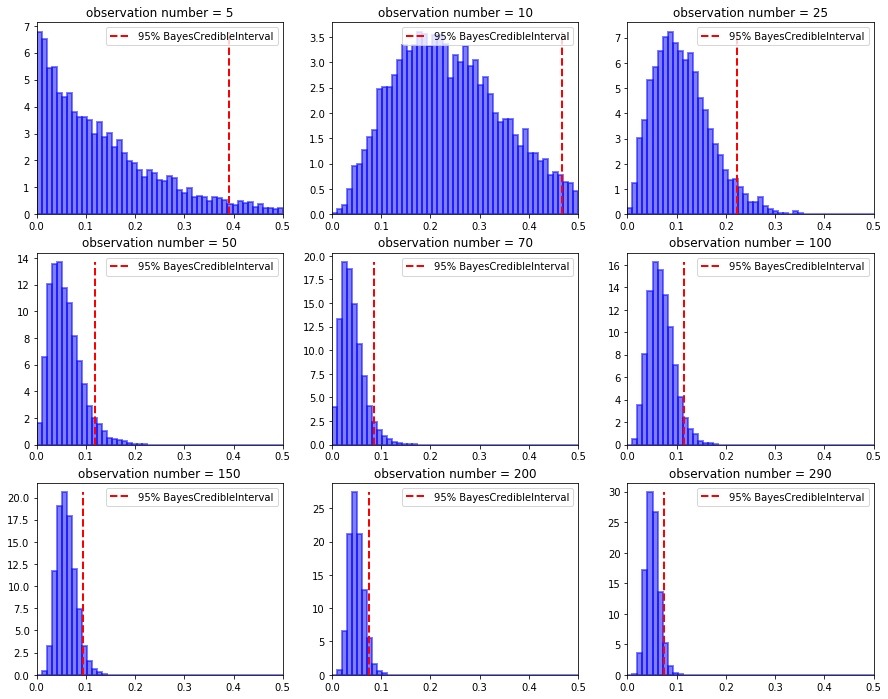

In [9]:
plt.figure(figsize=(15, 12))

#n_list = [2, 5, 10, 20, 30, 43]
n_list = [5, 10, 25, 50, 70, 100, 150, 200, 290]
cnt=0

for n in n_list:
    cnt+=1
    plt.subplot(3,3,cnt)
    p_trace = getMCMCResult(data_angel_s[:n])
    ret = plt.hist(p_trace['theta'], bins=np.linspace(0, 0.5, 50), normed=True, 
                   color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
    plt.xlim([0, 0.5])
    N = len(p_trace['theta'])
    bci = np.sort(p_trace['theta'])[int(N*0.95)]
    plt.vlines(x=bci, ymin=0, ymax=ret[0].max(), label='95% BayesCredibleInterval', 
               color='red', linestyles='--', linewidths=2)
    plt.legend()
    plt.title('observation number = %d'%n)